# Loading Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
X_train_path = '../data/processed/X_train.pkl'
X_test_path = '../data/processed/X_test.pkl'
y_train_path = '../data/processed/y_train.pkl'
y_test_path = '../data/processed/y_test.pkl'

X_train = pd.read_pickle(X_train_path)
X_test = pd.read_pickle(X_test_path)
y_train = pd.read_pickle(y_train_path)
y_test = pd.read_pickle(y_test_path)

In [3]:
X_train.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,C,C#,D,D#,E,F,F#,G,G#,Minor
0,0.424242,0.815936,0.640,0.454036,0.478,0.000000,0.405926,0.130257,0.138526,0.461006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.575758,0.962921,0.610,0.193658,0.283,0.000007,0.817496,0.109134,0.083691,0.353108,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.323232,0.980017,0.183,0.723030,0.232,0.993020,0.736447,0.065039,0.275023,0.268808,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.393939,0.107948,0.365,0.531238,0.413,0.000090,0.461439,0.115869,0.213209,0.409146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.525253,0.003761,0.305,0.429539,0.965,0.007909,0.839844,0.140167,0.552650,0.304065,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Choosing the Model

It can generally be observed that accuracy can increase most moving from algorithm to algorithm, for example +10% accuracy switching from K Nearest Neighbors to Random Forest, but that hyperparameter tuning yields smaller gains. Therefore, our procedure will be to pick the algorithm with default arguments, then fine tune the hyperparameters. Furthermore, this is a multiclass supervised learning problem, as the target data represents 10 genres of music. Therefore, we will pick our selection of algorithms to test from the [list of multiclass classifiers in scikit-learn](https://scikit-learn.org/stable/modules/multiclass.html). That said, it's import to be judicious in selecting an algorithm from this list, first because it will take too long if we try all of them, but secondly because our data is not appropriate for each classifier: [for example a Bernoulli Naive Bayes classifier requires feature vectors to be binary](https://scikit-learn.org/stable/modules/naive_bayes.html#bernoulli-naive-bayes).

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
# written in a way to easily comment out a classifer if it gives trouble with the data
models = list()
models.append(('KNN', KNeighborsClassifier(n_jobs=-1)))
models.append(('RNC', RadiusNeighborsClassifier(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('LSVC', LinearSVC()))
#models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('RC', RidgeClassifier()))
#models.append(('MLPC', MLPClassifier()))
models.append(('RFC', RandomForestClassifier(n_jobs=-1)))
models.append(('GBC', GradientBoostingClassifier()))

In [6]:
from sklearn.model_selection import cross_validate
scores = list()    

In [7]:
for model in models:
    cv_results = cross_validate(model[1], X_train, y_train, cv=10, n_jobs=-1)
    scores.append((model[0], cv_results['test_score']))

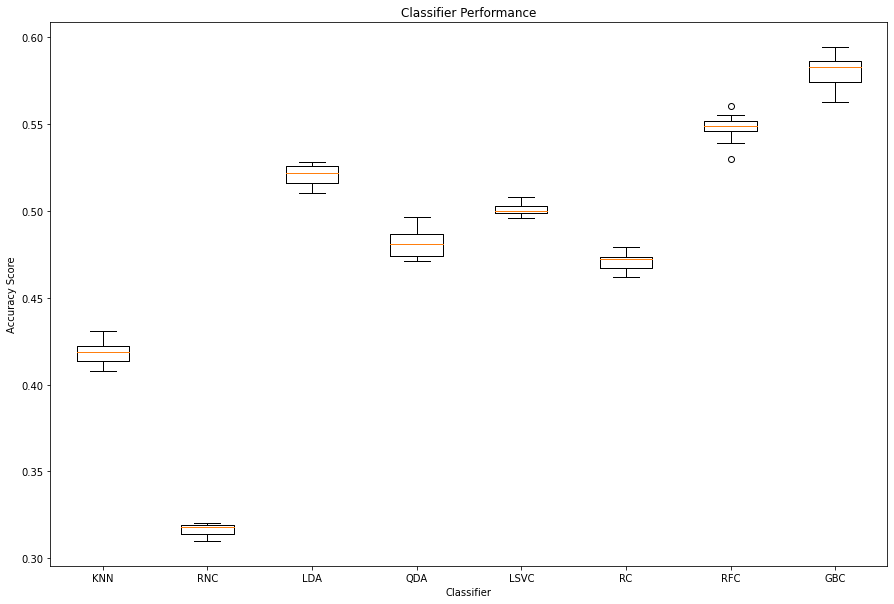

In [8]:
scores = list(zip(*scores))
fig = plt.figure(figsize =(15, 10))
ax = fig.add_subplot(111)
bp = ax.boxplot(scores[1], labels=scores[0])
ax.set_xlabel('Classifier')
ax.set_ylabel('Accuracy Score')
ax.set_title('Classifier Performance')
plt.show()

# Finding the hyperparameters

Looks like our Gradient Boosting Classifier performed the best. Now it's time to tune the hyper parameters for more gain.

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
param_grid = {'learning_rate': [0.01, 0.1],
              'n_estimators': [100, 400],
              'criterion': ['friedman_mse', 'squared_error'],
              'max_depth': np.arange(3, 12, 3),
              'max_features': ['sqrt', None]}

In [11]:
GBC = GradientBoostingClassifier()
clf = GridSearchCV(GBC, param_grid=param_grid, n_jobs=-1, cv=5)

In [12]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'learning_rate': [0.01, 0.1],
                         'max_depth': array([3, 6, 9]),
                         'max_features': ['sqrt', None],
                         'n_estimators': [100, 400]})

In [13]:
clf.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'max_depth': 3,
 'max_features': 'sqrt',
 'n_estimators': 400}

In [14]:
clf.best_score_

0.5842666666666667

# Fitting the model

In [15]:
model = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.1, max_depth=3, \
                                      max_features='sqrt', n_estimators=400).fit(X_train, y_train)

# Evaluating the model

In [17]:
print(model.score(X_test, y_test))

0.49048


In [18]:
y_pred = model.predict(X_test)

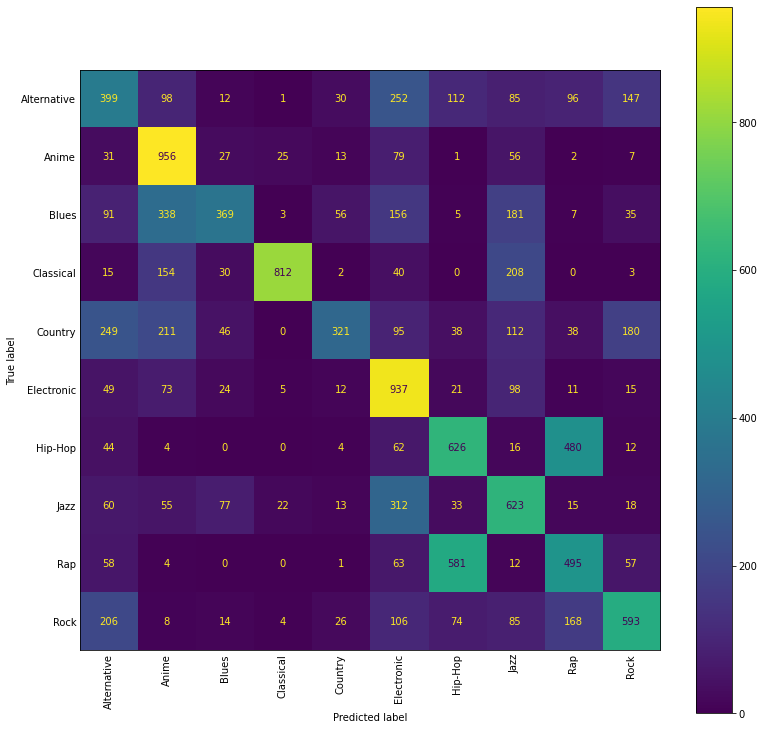

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(13,13))
disp.plot(ax=ax)
plt.tick_params(axis=u'both', which=u'both', length=0)
plt.xticks(ticks=range(0, 10), labels=model.classes_, rotation=90)
plt.yticks(ticks=range(0, 10), labels=model.classes_)
plt.grid(False)
plt.show()

# Reviewing the model

Going into a data set, it's not always clear what model to use. In this notebook, several models that can handle multilabel classification were chosen. From that set, a neural net MLP classifier and a logistic regression classifer were not used, because they require standardization which was not applied to this data set. Therefore, 8 models with default arguments were selected from scikit-learn for ranking. The data set features an equal distribution of labels, so accuracy was chosen as the scoring metric. Of the 8, the GradientBoostClassifier scored the highest, so this model was sent on to hyperparameter tuning. Once the highest scoring hyperparameters were found, they were used to create a new model which was fit to the entire training data set.

This final model achieved an accuracy of 49% on the test set, which is a large improvement over the 10% accuracy expected if observations were randomly assigned a label. Looking to the confusion matrix, it can be seen that certain musical genre labels can be predicted pretty well, such as Anime, Classical, and Electronic. The Anime label has a low precision, however: Blues, Classical, and Country are often wrongly predicted as Anime. This makes sense, because as a genre Anime is a soundtrack, meaning it can borrow from many other genres. At the other end of the spectrum, Country is predicted poorly. However, True Country gets misinterpreted as Alternative, Anime, and Rock quite often, and one would probably agree that in reality Country songs can be ALternative and Rock sounding. Lastly, there is poor differentiation between Rap and Hip-Hop, but these are two very similar genres with a lot of speechiness.

Thinking about a use case for this model, two possibilities come to mind. First, a user could input values for the type of music they want to hear into "accousticness", "danceability", etc., and be served a genre or song from a genre to listen to. Second, an app could suggest more similar music based on the currently playing song, and again pick a new song from within the genre or from genres that "bleed into" the first genre. In both cases, a listener may not notice interchange between Hip-Hop and Rap or Rock, Country, and Alternative, but would notice if randomly given a classical song. Fortunately, this model does a good job of this.

All in all, this model works pretty well, but of course there is a large margin of improvement from 49 - 100% accuracy. Future work may benefit from better feature engineering such as combined features. Standardization would open up the possibility of more model families to try, and may also have an inherent benefit. As seen in the EDA step, there is a large overlap between classes, so perhaps PCA would be a wise transformation to achieve better separation between the classes. There may also be better hyperparameters, and a better approach would use a method that is faster than GridSearchCV to cover a wider set of choices. These may be investigated at a later date.

Lastly, Gradient Boost is a fairly slow and complex model, and may not run on a small portable device meant for playing music. Especially considering the need to retrain regularly to keep up with the growing trends of genres as new music is released. A future project might try to fit the second highest scoring Random Forest instead, even at the penalty of some accuracy if it can do more in real time.

# Saving the data

In [37]:
clf_path = '../models/GBC_model_GridSearchCV.pkl'
model_path = '../models/GBC_model.pkl'
y_pred_path = '../data/processed/y_pred.pkl'

with open(model_path, 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(clf_path, 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(y_pred_path, 'wb') as handle:
    pickle.dump(y_pred, handle, protocol=pickle.HIGHEST_PROTOCOL)